# Hack The Feed: Insights From Social Media Data

This notebook presents the results of our analysis and visualization of the Playhouse Communications facebook dataset for the Dicey Tech hackathon. Each notebook is a standalone file that can be run from the top down to reproduce the findings of our analysis.

## Data loading and pre-processing

In [1]:
import pandas as pd
import numpy as np

file = "../data/facebook.csv"

df = pd.read_csv(file, low_memory=False, parse_dates=[0])

/var/folders/yw/m_924cdx5sv965q742rtv_p40000gn/T/ipykernel_60410/2669788710.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, low_memory=False, parse_dates=[0])


In [2]:
%cd ..

/Users/mac/Documents/development/Hack_the_feed


In [3]:
from src.clean_data import clean_df

In [4]:
new_df = clean_df(df)
new_df.index = pd.to_datetime(new_df.index)
new_df.head()

,Content Type,Sent by,Link,Post,Linked Content,Impressions,Organic Impressions,Viral Impressions,Non-viral Impressions,Paid Impressions,...,Unique Video Views,Unique Organic Video Views,Unique Paid Video Views,Unique 10-Second Video Views,Unique Full Video Views,Unique Organic 95% Video Views,Unique Paid 95% Video Views,Tags,Time,Time Period
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-15,Link,,https://www.facebook.com/253788558082460/posts...,NaN,https://www.facebook.com/253788558082460/posts...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:25:00,afternoon
2013-01-16,Photo,,https://www.facebook.com/media/set/?set=a.2714...,NaN,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:51:00,afternoon
2013-01-16,Photo,,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:58:00,afternoon
2013-01-17,Photo,,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17:08:00,evening
2013-02-01,Photo,,https://www.facebook.com/media/set/?set=a.2828...,NaN,https://www.facebook.com/StanbicIBTC/photos/a....,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:24:00,afternoon


## Analysis and Visualization


###  Impressions and Reach
The following sub-sections provide insights on the `Impressions` and `Reach` of the facebook posts.

#### QUESTION: What type of content generates the most impressions?

In [5]:
# create a slice of the dataframe containing non-zero values for the `Impression` column.
valid_impressions = new_df[(new_df["Impressions"] != 0) & ~new_df["Impressions"].isna()]

# group by `Content Type` and calculate the mean `Impressions for each content type
content_df = (
    valid_impressions.groupby("Content Type")["Impressions"]
    .mean()
    .reset_index()
    .sort_values("Impressions", ascending=False)
)

In [6]:
# import necessary plotting libraries
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [7]:
# create a bar chart showing the average impressions by content type
from bokeh.plotting import figure, output_file, show

x_range = content_df["Content Type"]
y_range = content_df["Impressions"]

p = figure(
    title="Average Impressions by Content Type",
    x_range=x_range,
    height=400,
    width=600,
    y_axis_label="Average Impression",
)

p.vbar(x=x_range, top=y_range, width=0.8)

p.yaxis.minor_tick_out = 0
p.y_range.start = 1000

show(p)

#### QUESTION: What is the trend of impressions over the years?

In [8]:
# import relevant plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

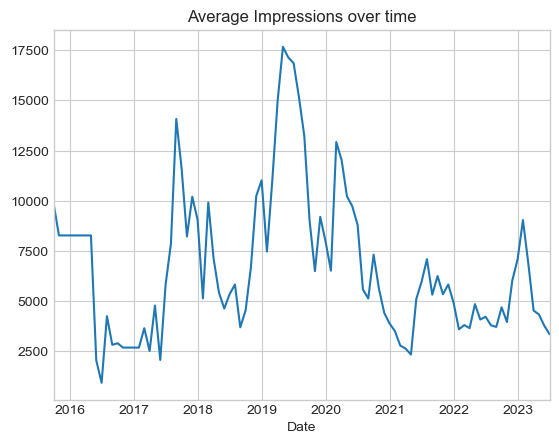

In [9]:
# calculate the mean impressions per month
mmi = valid_impressions["Impressions"].resample("M").mean()

# forward fill the data for months with empty values and generate a line plot
ax = mmi.fillna(method="ffill").plot(title="Average Impressions over time")

plt.show();

#### QUESTION: When is the best time to post on Facebook?

In [10]:
# group the dataframe by content type and time period the post was made
cbt = (
    valid_impressions.groupby(["Content Type", "Time Period"])["Reach"]
    .mean()
    .reset_index()
)

time_period_order = ["morning", "afternoon", "evening"]

# arrange the time period in order of morning, afternoon, and evening.
cbt["Time Period"] = pd.Categorical(
    cbt["Time Period"], categories=time_period_order, ordered=True
)

# sort the grouped dataframe by time period order
cbt = cbt.sort_values(["Content Type", "Time Period"])
cbt.reset_index(drop=True, inplace=True)

In [11]:
# slice the grouped dataframe into content types
link = cbt.iloc[:3]
link.name = "Links"

photo = cbt.iloc[3:6]
photo.name = "Photos"

text = cbt.iloc[6:9]
text.name = "Texts"

video = cbt.iloc[9:]
video.name = "Videos"

content = (link, photo, text, video)

In [12]:
# create a function that plots a Bokeh bar chart for the time period data.
def plot_bar(df):
    p = figure(title=df.name, x_range=list(df["Time Period"]), height=300, width=400)

    p.vbar(x="Time Period", top="Reach", color="#99CCFF", source=df, width=0.8)

    p.axis.major_tick_out = 0

    p.xgrid.grid_line_color = None

    p.yaxis.axis_label = "Average Reach"
    p.yaxis.minor_tick_out = 0
    p.y_range.start = 1000
    p.y_range.end = 9000

    return p

In [13]:
# import the gridplot function to display the plots in a gridplot
from bokeh.layouts import gridplot

# create an empty list and append the bar plots in list
plots = []
for c in content:
    plot = plot_bar(c)
    plots.append(plot)

# create a 2x2 layout for the plots and display it
layout = gridplot(plots, ncols=2, toolbar_location=None)
show(layout)

#### QUESTION: What type of content has the broadest appeal?

In [14]:
# group sliced dataframe by content type and calaculate the mean "Organic Reach"
org_reach = (
    valid_impressions.groupby("Content Type")["Organic Reach"].mean().reset_index()
)

# sort the grouped in descending order
org_reach.sort_values("Organic Reach", ascending=False, inplace=True)

In [15]:
# create a bar chart showing the average organic reach by content type
from bokeh.plotting import figure, show

x_range = org_reach["Content Type"]
y_range = org_reach["Organic Reach"]

p = figure(
    title="Average organic reach of content",
    x_range=x_range,
    height=400,
    width=600,
    y_axis_label="Average Organic Reach",
)

p.vbar(x=x_range, top=y_range, width=0.8)

p.yaxis.minor_tick_out = 0
p.y_range.start = 1000

show(p)

#### QUESTION: How often do users click on shared links?

In [16]:
# slice the `valid_impressions` dataframe to include only the rows with values for `Linked Content` and `Click-Through Rate`
linked = valid_impressions[
    (~valid_impressions["Linked Content"].isna())
    & (~valid_impressions["Click-Through Rate"].isna())
]

# convert the `Click-Through Rate` column to float values (decimal numbers)
linked.loc[:, "Click-Through Rate"] = linked["Click-Through Rate"].apply(
    lambda x: float(x.replace(",", "").replace("%", ""))
)

# group the `linked` dataframe by `Content Type` and calculate the mean `Click-Through Rate(ctr)`
ctr = (
    linked.groupby("Content Type")["Click-Through Rate"]
    .mean()
    .reset_index()
    .sort_values("Click-Through Rate", ascending=False)
)

In [17]:
# plot a bar chart to show the ctr for each content type
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

# Convert the DataFrame to a ColumnDataSource
source = ColumnDataSource(ctr)

# Create a Bokeh figure
p = figure(
    title="Click-through rate for each content type",
    x_range=ctr["Content Type"],
    y_axis_label="Click through rate",
)

p.vbar(x="Content Type", top="Click-Through Rate", source=source, width=0.8)

p.y_range.start = 0

show(p)